# Schmitt Trigger using a CMOS Transistor

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PySpice.Spice.Netlist import (
    Circuit, SubCircuitFactory
)
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.WaveForm import OperatingPoint

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Objective

The objective of this chapter is to present the design of a Schmitt trigger implemented using CMOS transistors. In the previous chapter, a Schmitt trigger based on bipolar transistors was analyzed. While bipolar solutions are functionally effective, they are relatively complex to implement at the layout and process layer level, particularly in the context of digital integrated circuits.

By contrast, CMOS technology offers a much simpler and more scalable fabrication process. It is therefore far better suited for large-scale integration and low-power digital systems. As a result, CMOS-based Schmitt triggers are widely adopted in modern electronic designs, especially in integrated digital and mixed-signal applications.

### Circuit

The circuit is shown in Figure [](#CMOS_circuit). It consists of four CMOS transistors: two PMOS transistors and two NMOS transistors arranged to implement a Schmitt trigger behavior.

```{figure} ./images/CMOS_circuit.svg
:name: CMOS_circuit
:align: center
:width: 400px

CMOS-based Schmitt trigger circuit
```

The objective of the next section is to analyze the operating principle of this circuit and to understand how the interaction between the transistors creates the hysteresis effect.

## Compréhension du circuit

### Porte Inverseur

Tout d'abord, il est possible de voir qu'il y a un schéma très proche d'un circuit inverseur avec les transistors *M2* et *M3*. La [](#CMOS_circuit_firt_part) permet de visualiser le montage.

```{figure} ./images/CMOS_circuit_firt_part.svg
:name: CMOS_circuit_firt_part
:align: center
:width: 200px

Montage inverseur avec CMOS
```

Le montage est très simple a comprendre la [](#CMOS_circuit_firt_part_demonstration) résume sont fonctionnement. 
* Lorsqu'il y a un niveau haut ou un ``1`` en entrée alors :
  * Le transistor $M_2$ est bloqué
  * Le transistor $M_3$ est passant et donc la sortie $V_{int}$ est relier à la masse ce qui va donner un niveau bas ou ``0``.
* A l'inverse lorsqu'il y a un niveau bas ou un ``0`` en entrées alors :
  * Le transistor $M_3$ est bloqué
  * Le transistor $M_2$ est passant et donc la sortie $V_{int}$ est relier à la sortie $V_DD$ du circuit et donc au niveau haut ou ``1``.

```{figure} ./images/CMOS_circuit_firt_part_demonstration.svg
:name: CMOS_circuit_firt_part_demonstration
:align: center
:width: 500px

Visualisation des CMOS dans un montage inverseur
```

Les lignes de code a pour objectif de simuler cette partie de signal

In [3]:
Wn_list = (0.1, 0.1, 0.1) 
Wp_list = (0.2, 0.5, 4)
list_in  = []
list_out = [] 

for Wn, Wp in zip(Wn_list, Wp_list) :
    circuit = Circuit('CMOS Inverter')
    
    circuit.include('lib/ptm_65nm_nmos_bulk.mod')
    circuit.include('lib/ptm_65nm_pmos_bulk.mod')
    
    # Alimentation
    VDD = 1.2
    circuit.V('dd', 'vdd', circuit.gnd, VDD@u_V)
    
    # Entrée
    circuit.V('in', 'vin', circuit.gnd, 0@u_V)
    
    # NMOS
    circuit.MOSFET(
        'n',
        'vout', 'vin', circuit.gnd, circuit.gnd,
        model='ptm65nm_nmos',
        l=.35@u_um,
        w=Wn@u_um        
    )
    
    # PMOS
    circuit.MOSFET(
        'p',
        'vout', 'vin', 'vdd', 'vdd',
        model='ptm65nm_pmos',
        l=.35@u_um,
        w=Wp@u_um      # ← à modifier
    )

    
    simulator = circuit.simulator(temperature=25)
    analysis = simulator.dc(Vin=slice(0, VDD, 0.01))

    list_in.append(analysis['vin']) 
    list_out.append(analysis['vout'])

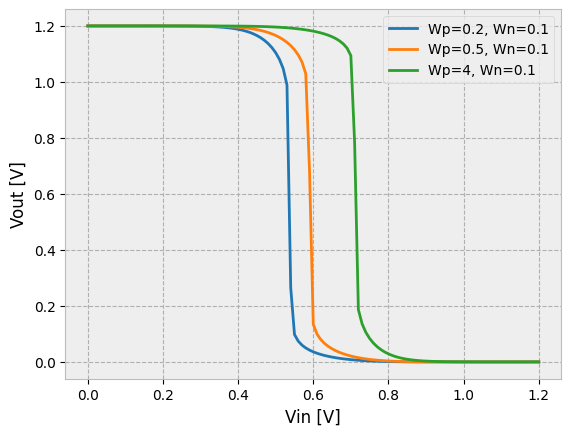

In [4]:
plt.figure()

for inp, out, Wp, Wn in zip(list_in, list_out, Wp_list, Wn_list) :
    plt.plot(inp, out, label=f'Wp={Wp}, Wn={Wn}')
plt.legend(loc='upper right')
plt.xlabel('Vin [V]')
plt.ylabel('Vout [V]')
plt.show()

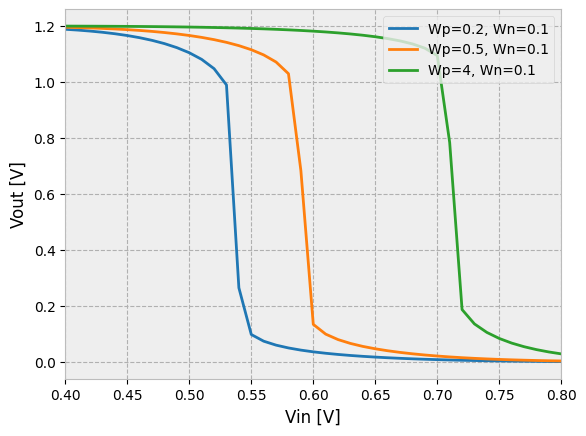

In [14]:
plt.figure()

for inp, out, Wp, Wn in zip(list_in, list_out, Wp_list, Wn_list) :
    plt.plot(inp, out, label=f'Wp={Wp}, Wn={Wn}')
plt.legend(loc='upper right')
plt.xlabel('Vin [V]')
plt.ylabel('Vout [V]')
plt.xlim(.4, .8)
plt.show()

Plusieurs points sont à noté sur se graphique. 

Tout d'abord, il est possible de bien voir la porte inverseur. Lorsque $V_{in}$ est faible alors il est possible de voir que la tension de sortie $V_{out}$ est importante et vis-versa. Si la tension d'entrée est forte $V_{in}$, alors il est possible de voir que la tension de sortie est faible $V_{out}$.

Un autre point qui est important est que les palier change en fonction de la taille de la grille, *w* / *l* ([](#CMOS_circuit_W_L)) il est possible de voir que la tension de seuil change. C'est un des points très importants pour jouer sur les valeurs seuils. 


```{figure} ./images/CMOS_circuit_W_L.svg
:name: CMOS_circuit_W_L
:align: center
:width: 400px

Dimension W L d'une grille sur un composant CMOS
```

Le dernier point important est que les palier ne sont pas aussi propre que prévu. Lorsqu'on dessine les paliers le résultat attendu est la chose suivante donc ce sont des palier parfaitement plan (or dans notre cas se n'est pas le cas). De plus les transistion ne sont pas parfaitement vertical. 

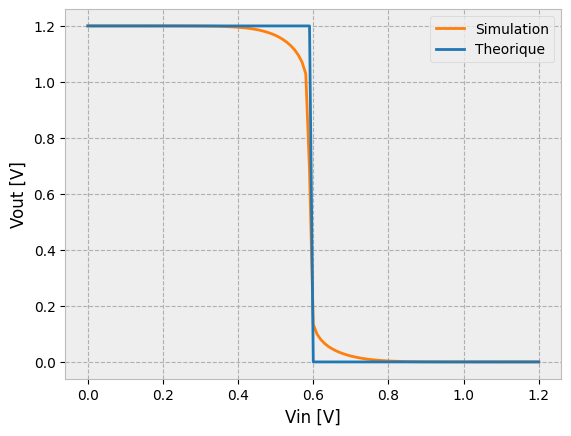

In [6]:
transition = 60
nbr_point = list_in[1].shape[0]

plt.figure()
plt.plot(list_in[1], list_out[1], label="Simulation", c='C1')
plt.plot(list_in[1], 
         np.concatenate([VDD*np.ones(transition), np.zeros(nbr_point - transition)]),
         label="Theorique")
plt.legend(loc='upper right')
plt.xlabel('Vin [V]')
plt.ylabel('Vout [V]')
plt.show()

## Compréhension du circuit complet

Maintenant, que nous avons étudier rapidement une porte inverseuse, l'objectif cette fois est d'étudier, le circuit complet. 

Mais avant de cela il faut des briques en plus, qui n'ont pas encore été énoncé, l'un de ces briques et la valeur de seuil $V_{TH}$

### Valeur de seuil 

#### Transistor NMOS

Tout d'abord, la valeur de seuil d'un NMOS $V_\text{THN}$ est la tension grille-source miminmales à partie de laquelle :
* un canal d'inversion n se forme
* le transistor commence à conduire

Pour cela il faut que la tension entre la la grille et la source soit supérieur à cette tension de seuil :

$$V_{GS} \approx V_{THN}$$

Donc l'objectif est de déterminer cette valeur de $V_{THN}$.

$$
V_{THN} = V_{FB} + 2\phi_F + \gamma
\left(\sqrt{2\phi_F + V_{SB}} - \sqrt{2\phi_F}\right)
$$

avec :
* $V_{FB}$ - tension de bande plate : $V_{FB} = \Phi_{MS} - \frac{Q_{ox}}{C_{ox}}$
* $\phi_F$ - potentiel de Fermi : $\phi_F = \frac{kT}{q}\ln\left(\frac{N_A}{n_i}\right)$
* $\gamma$ - coefficient d’effet de substrat : $\gamma = \frac{\sqrt{2q\varepsilon_{si}N_A}}{C_{ox}}$
* $V_{SB}$ - tension source–bulk : **effet body**

In [ ]:
Très bonne question — c’est **fondamental** pour comprendre ton trigger de Schmitt 👍
Je vais répondre **de façon progressive**, du **physique** au **pratique en SPICE**, avec les **formules clés**.

---

# 1️⃣ Définition de ( V_{THN} )

Le **seuil d’un NMOS** ( V_{THN} ) est la **tension grille–source minimale** à partir de laquelle :

* un **canal d’inversion n** se forme
* le transistor commence à conduire

Condition :
[
V_{GS} \ge V_{THN}
]

---

# 2️⃣ Formule physique complète (MOS long canal)

La formule théorique est :

[
\boxed{
V_{THN} = V_{FB} + 2\phi_F + \gamma
\left(\sqrt{2\phi_F + V_{SB}} - \sqrt{2\phi_F}\right)
}
]

### Où :

### 🔹 ( V_{FB} ) — tension de bande plate

[
V_{FB} = \Phi_{MS} - \frac{Q_{ox}}{C_{ox}}
]

### 🔹 ( \phi_F ) — potentiel de Fermi

[
\phi_F = \frac{kT}{q}\ln\left(\frac{N_A}{n_i}\right)
]

### 🔹 ( \gamma ) — coefficient d’effet de substrat

[
\gamma = \frac{\sqrt{2q\varepsilon_{si}N_A}}{C_{ox}}
]

### 🔹 ( V_{SB} ) — tension source–bulk

→ **effet body**

---

# 3️⃣ Cas simplifié (bulk = source)

Dans **90 % des circuits CMOS** :

[
V_{SB} = 0
]

Donc :
[
\boxed{
V_{THN} = V_{TH0}
}
]

avec :
[
V_{TH0} = V_{FB} + 2\phi_F
]

👉 C’est **le seuil nominal** fourni par la techno.

---

# 4️⃣ Valeurs typiques (ordre de grandeur)

| Technologie | ( V_{THN} )   |
| ----------- | ------------- |
| 180 nm      | 0.45 – 0.55 V |
| 130 nm      | 0.40 – 0.50 V |
| 65 nm       | 0.30 – 0.45 V |
| Low-Vt      | 0.20 – 0.30 V |

➡️ En **PTM 65 nm**, typiquement :
[
V_{THN} \approx 0.35\ \text{V}
]

---

# 5️⃣ Influence de l’effet body (important dans ton Schmitt)

Si **source ≠ bulk**, alors :

[
\Delta V_{TH} = \gamma
\left(\sqrt{2\phi_F + V_{SB}} - \sqrt{2\phi_F}\right)
]

👉 Exemple :

* ( \gamma = 0.4 )
* ( 2\phi_F = 0.6 )
* ( V_{SB} = 0.4 )

[
\Delta V_{TH} \approx 0.11\ \text{V}
]

➡️ **Le seuil augmente** → exactement ce qui crée l’hystérésis.

---

# 6️⃣ Modèle pratique (SPICE niveau circuit)

En analyse logique / Schmitt :

[
V_{THN,\text{eff}} \approx V_{TH0} + \gamma \left(\sqrt{2\phi_F + V_{SB}} - \sqrt{2\phi_F}\right)
]

Et le transistor commence à conduire quand :
[
V_{in} > V_{source} + V_{THN,\text{eff}}
]

---

# 7️⃣ Comment obtenir ( V_{THN} ) dans SPICE

### 📌 Méthode 1 — Lire le modèle

Dans ton fichier `.mod` :

```spice
VTH0 = 0.36
GAMMA = 0.45
PHI = 0.6
```

### 📌 Méthode 2 — Simulation DC

```spice
.dc Vin 0 1.2 1m
```

→ Observer le courant ( I_D ) vs ( V_{GS} )

---

# 8️⃣ Lien direct avec ton Schmitt trigger

Dans ton montage :

* Quand `vinter` monte → ( V_{SB} \uparrow )
* Donc ( V_{THN} \uparrow )
* Donc le seuil de bascule change

👉 **L’hystérésis vient directement de la dépendance de ( V_{TH} ) à ( V_{SB} )**

---

## 🔥 En une phrase

> Le seuil d’un NMOS se calcule à partir de son seuil nominal **modifié par l’effet body**, et c’est exactement ce mécanisme que ton trigger de Schmitt exploite.

Si tu veux, je peux maintenant :

* 🔬 Calculer **les seuils haut et bas** de TON montage
* 📊 Faire le lien **équations ⇄ simulation**
* 🧠 T’expliquer la même chose côté **PMOS**

Dis-moi 👌


## Simulation du circuit complet

In [18]:
# ============================================================
# CMOS AND Gate (implemented as NAND + inverter if needed)
# Technology: PTM 65 nm
# ============================================================

# Create the circuit object
circuit = Circuit('Hysteresis CMOS')

# ============================================================
# Model Libraries
# Include NMOS and PMOS transistor models
# ============================================================

circuit.include('lib/ptm_65nm_nmos_bulk.mod')
circuit.include('lib/ptm_65nm_pmos_bulk.mod')

# ============================================================
# Power Supply Definition
# ============================================================

# Supply voltage
VDD = 1.2

# DC power supply (VDD)
circuit.V('dd', 'vdd', circuit.gnd, VDD @ u_V)


# ============================================================
# Input Signal Definitions
# Two pulse voltage sources are used to test all logic states
# ============================================================
f = 2                        # fréquence [Hz]
V_offset = VDD/2             # offset DC
V_amplitude = VDD/2          # amplitude du signal sin
delay = 0

circuit.SinusoidalVoltageSource(
    'in', 'vin', circuit.gnd,
    offset=V_offset @ u_V,
    amplitude=V_amplitude @ u_V,
    frequency=f @ u_Hz,
    delay=delay @ u_s
)

# ============================================================
# CMOS Logic Core
# Trigger Implementation
# ============================================================
circuit.MOSFET(
    1,
    'v-', 'vin', 'vdd', 'vdd',
    model='ptm65nm_pmos',
    l=0.35 @ u_um,
    w=0.5 @ u_um
)

circuit.MOSFET(
    2,
    'v-', 'vin', 'vinter', 'vdd',
    model='ptm65nm_pmos',
    l=0.35 @ u_um,
    w=0.5 @ u_um
)

circuit.MOSFET(
    3,
    'v+', 'vin', 'vinter', circuit.gnd,
    model='ptm65nm_nmos',
    l=0.35 @ u_um,
    w=0.1 @ u_um
)

circuit.MOSFET(
    4,
    'v+', 'vin', circuit.gnd, circuit.gnd,
    model='ptm65nm_nmos',
    l=0.35 @ u_um,
    w=0.1 @ u_um
)

circuit.MOSFET(
    5,
    'v-', 'vinter', circuit.gnd, 'vdd',
    model='ptm65nm_pmos',
    l=0.35 @ u_um,
    w=0.5 @ u_um
)

circuit.MOSFET(
    6,
    'v+', 'vinter', 'vdd', circuit.gnd,
    model='ptm65nm_nmos',
    l=0.35 @ u_um,
    w=0.1 @ u_um
);

In [19]:
# ------------------------------------------------------------
# Transient Simulation
# ------------------------------------------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

analysis = simulator.transient(
    step_time=1@u_ms,    # pas de temps : 1 ms (à ajuster si besoin)
    end_time=2@u_s       # durée totale : 2 secondes
)

# ============================================================
# End of Transient Simulation
# ============================================================

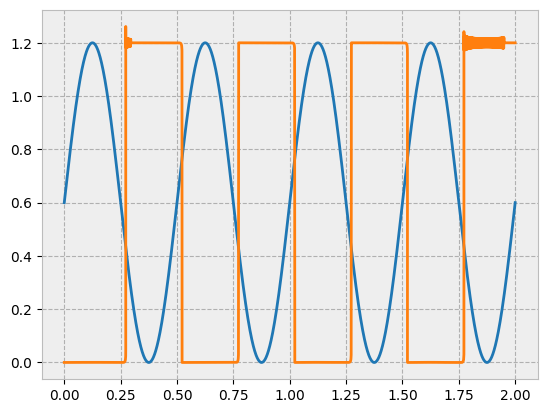

In [21]:
plt.plot(analysis.time, analysis["vin"])
plt.plot(analysis.time, analysis["vinter"])
plt.show()

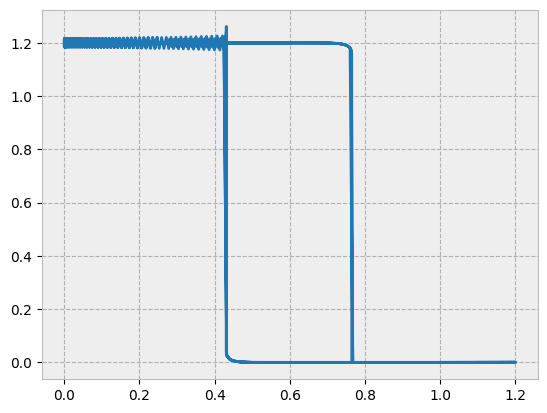

In [22]:
plt.plot(analysis["vin"], analysis["vinter"])